In [203]:
import torch
import networkx as nx
from torch_geometric.nn import SAGEConv, to_hetero
from torch import optim
import torch_geometric.transforms as T
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import accuracy_score, recall_score, f1_score
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from torch_geometric.data import HeteroData
from evaluation import *
from NN_Models import *
import json
import numpy as np
import pandas as pd
from preprocessing import *

In [2]:
f = open('../../data/train.json', 'rb')
train_raw = json.load(f)

f = open('../../data/test.json', 'rb')
test_raw = json.load(f)

f_train = open("data/discard_index.json", 'r')
discard = json.load(f_train)['discard_index']

In [15]:
num_words = 4999
num_coauthor = 21245-100+1
num_class = 100
num_venue = 465
num_year = 20

In [3]:
print("discard length = ", len(discard))
print("remain data length = ", len(train_raw) - len(discard))
train_len = int(0.8 * (len(train_raw) - len(discard)))
print("train length : ", train_len)

print("train keys  : ", train_data[0].keys())
print("test keys   : ", test_data[0].keys())

discard length =  16439
remain data length =  9354
train length :  7483
train keys  :  dict_keys(['authors', 'year', 'abstract', 'venue', 'title'])
test keys   :  dict_keys(['identifier', 'coauthors', 'year', 'abstract', 'venue', 'title'])


### Create Heterogenous Dataset

In [4]:
train_df = pd.DataFrame(columns=['year', 'venue', 'coauthor', 'pauthor', 'text', 'train_mask', 'val_mask', 'test_mask'])

index = 0
for i in tqdm(range(len(train_raw)), desc="creating hetero data (train)"):
    if i not in discard:
        train_df.loc[index, 'year'] = train_raw[i]['year']
        if train_raw[i]['venue']:
            train_df.loc[index, 'venue'] = train_raw[i]['venue']
        else:
            train_df.loc[index, 'venue'] = -1
        coauthor = [0 for _ in range(num_coauthor)]
        pauthor = [0 for _ in range(num_class)]
        for j in train_raw[i]['authors']:
            if j < 100:
                pauthor[j] += 1
            else:
                coauthor[j-num_class] += 1
        train_df.loc[index, 'coauthor'] = coauthor
        train_df.loc[index, 'pauthor'] = pauthor
        train_df.loc[index, 'text'] = train_raw[i]['abstract'] + train_raw[i]['title']
        if index < train_len:
            train_df.loc[index, 'train_mask'] = False
            train_df.loc[index, 'val_mask'] = True
        else:
            train_df.loc[index, 'train_mask'] = True
            train_df.loc[index, 'val_mask'] = False
        train_df.loc[index, 'test_mask'] = True
        index += 1

for i in tqdm(range(len(test_raw)), desc="creating hetero data (kaggle)"):
    
    train_df.loc[index, 'year'] = test_raw[i]['year']
    if test_raw[i]['venue']:
        train_df.loc[index, 'venue'] = test_raw[i]['venue']
    else:
        train_df.loc[index, 'venue'] = -1
    
    coauthor = [0 for _ in range(num_coauthor)]
    pauthor = [0 for _ in range(num_class)]
    for j in train_raw[i]['authors']:
        coauthor[j-num_class] += 1

    train_df.loc[index, 'coauthor'] = coauthor
    train_df.loc[index, 'pauthor'] = pauthor
    train_df.loc[index, 'text'] = test_raw[i]['abstract'] + test_raw[i]['title']
    
    train_df.loc[index, 'train_mask'] = True
    train_df.loc[index, 'val_mask'] = True
    train_df.loc[index, 'test_mask'] = False
    index += 1

train_df['id'] = train_df.index

creating hetero data (kaggle): 100%|██████████| 800/800 [00:02<00:00, 273.31it/s]


In [5]:
train_df.head(2)

,year,venue,coauthor,pauthor,text,train_mask,val_mask,test_mask,id
0,9,20,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[2455, 1858, 2335, 1543, 1800, 1860, 2000, 286...",False,True,True,0
1,15,2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[40, 1542, 1691, 2449, 1535, 3616, 2206, 1904,...",False,True,True,1


In [6]:
def get_tagged_document(df):
   return [TaggedDocument(words=doc, tags=[i]) for i, doc in zip(df.index, df.text)]
   
tagged_document = get_tagged_document(train_df)

model_d2v = Doc2Vec(vector_size=300, min_count=10,epochs=100,dm=1,window=5)
model_d2v.build_vocab(tagged_document)

model_d2v.train(tagged_document,
              total_examples=model_d2v.corpus_count,
              epochs=model_d2v.epochs)

In [7]:
# tagged_document
train_df['doc2vec'] = train_df.id.apply(lambda x:model_d2v[x])

In [8]:
train_df.head(2)

,year,venue,coauthor,pauthor,text,train_mask,val_mask,test_mask,id,doc2vec
0,9,20,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[2455, 1858, 2335, 1543, 1800, 1860, 2000, 286...",False,True,True,0,"[0.56858, 0.4268763, -0.13476771, 0.49347693, ..."
1,15,2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[40, 1542, 1691, 2449, 1535, 3616, 2206, 1904,...",False,True,True,1,"[0.5308693, -0.36671042, -1.0341024, 0.680285,..."


In [26]:
coauthor_node = torch.zeros([num_coauthor, num_year])

for i in tqdm(train_df.index, total=len(train_df)):
    coauthor = train_df.loc[i, 'coauthor']
    year = train_df.loc[i, 'year']
    for j in range(num_coauthor):
        if coauthor[j] == 1:
            coauthor_node[j, year] += 1

coauthor_node.shape

100%|██████████| 10154/10154 [00:24<00:00, 422.07it/s]


torch.Size([21146, 20])

In [27]:
venue_node = torch.zeros([num_venue, num_coauthor])

for i in tqdm(train_df.index, total=len(train_df)):
    coauthor = train_df.loc[i, 'coauthor']
    venue = train_df.loc[i, 'venue']
    if venue != -1:
        for j in range(num_coauthor):
            if coauthor[j] == 1:
                venue_node[venue, j] += 1

venue_node.shape

100%|██████████| 10154/10154 [00:17<00:00, 594.68it/s]


torch.Size([465, 21146])

In [166]:
data = HeteroData()

data['paper'].x = torch.tensor(train_df.doc2vec)
data['paper'].train_mask = torch.tensor(train_df.train_mask)
data['paper'].test_mask = torch.tensor(train_df.test_mask)
data['paper'].val_mask = torch.tensor(train_df.val_mask)
data['paper'].y = torch.tensor(train_df.pauthor, dtype=torch.float32)

data['coauthor'].x = coauthor_node
data['venue'].x = venue_node

### Edges

In [110]:
from itertools import combinations

write_edges = []
for j in tqdm(train_df.index, total=len(train_df)):
    written_author = []
    coauthor = train_df.loc[j, 'coauthor']

    for i in range(num_coauthor):
        if coauthor[i] == 1:
            write_edges.append([i, j])

publish_edges = []
for j in tqdm(train_df.index, total=len(train_df)):
    publish = []
    venue = train_df.loc[j, 'venue']
    if venue != -1:
        publish_edges.append([j, venue])

100%|██████████| 10154/10154 [00:00<00:00, 86476.81it/s]


In [112]:
torch.tensor(write_edges).T

tensor([[13620,  1259, 15781,  ..., 13764, 15486, 17480],
        [    0,     1,     1,  ..., 10153, 10153, 10153]])

In [167]:
data['coauthor', 'write', 'paper'].edge_index = torch.LongTensor(write_edges).T
data['paper', 'published', 'venue'].edge_index = torch.LongTensor(publish_edges).T
data

HeteroData(
  paper={
    x=[10154, 300],
    train_mask=[10154],
    test_mask=[10154],
    val_mask=[10154],
    y=[10154, 100]
  },
  coauthor={ x=[21146, 20] },
  venue={ x=[465, 21146] },
  (coauthor, write, paper)={ edge_index=[2, 26613] },
  (paper, published, venue)={ edge_index=[2, 7777] }
)

In [168]:
data = T.ToUndirected()(data)
data

HeteroData(
  paper={
    x=[10154, 300],
    train_mask=[10154],
    test_mask=[10154],
    val_mask=[10154],
    y=[10154, 100]
  },
  coauthor={ x=[21146, 20] },
  venue={ x=[465, 21146] },
  (coauthor, write, paper)={ edge_index=[2, 26613] },
  (paper, published, venue)={ edge_index=[2, 7777] },
  (paper, rev_write, coauthor)={ edge_index=[2, 26613] },
  (venue, rev_published, paper)={ edge_index=[2, 7777] }
)

In [173]:
class GNN(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = SAGEConv((-1, -1), hidden_channels)
        self.conv2 = SAGEConv((-1, -1), out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)
        return torch.sigmoid(x)


model = GNN(hidden_channels=64, out_channels=num_class)
model = to_hetero(model, data.metadata(), aggr='sum')

In [178]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

def train(epochs=10):
    loss_list = []
    for epoch in tqdm(range(epochs)):
        model.train()
        optimizer.zero_grad()
        out = model(data.x_dict, data.edge_index_dict)
        mask = data['paper'].val_mask
        loss = nn.BCELoss()(out['paper'][~mask], data['paper'].y[~mask])
        loss.backward()
        optimizer.step()

        loss_list.append(loss.item())
    
    return loss_list

In [182]:
loss_list = train(100)

100%|██████████| 100/100 [03:52<00:00,  2.33s/it]


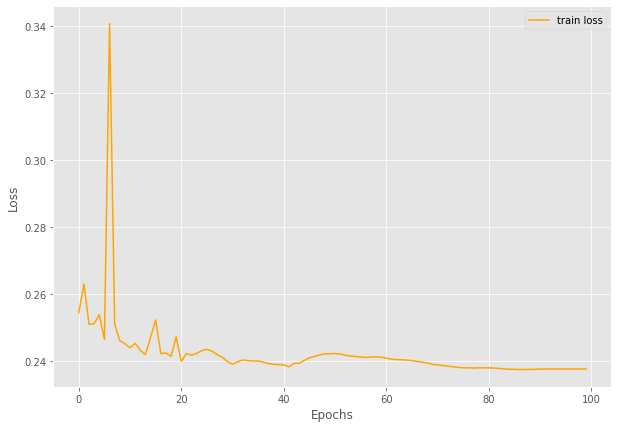

In [183]:
n = Model()
n.train_loss = loss_list
n.plot_loss()

In [184]:
logits = model(data.x_dict, data.edge_index_dict)

In [225]:
val_mask = data['paper'].val_mask
test_list = to_list(data['paper'].y[~val_mask])
# test_list

In [226]:
val_logits = logits['paper'][~val_mask]

pred_list = []
threshold = 0.9
for i in range(len(val_logits)):
    pred_au = ""
    for j in range(100):
        if val_logits[i, j] > threshold:
            pred_au += str(j) + " "
    if pred_au:
        pred_list.append(pred_au[:-1])
    else:
        pred_list.append('-1')


In [227]:
print_scores(test_list, pred_list)

=========================Evaluation results=========================
The accuracy score of prediction is : 0.7760555852485302
The recall   score of prediction is : 0.7760555852485302
The f1       score of prediction is : 0.7829672002776766


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Kaggle

In [246]:
threshold = 0.05

test_mask = data['paper'].test_mask

test_logits = logits['paper'][~test_mask]

kaggle_predict = []

for i in range(len(test_logits)):
    pred_au = ""
    for j in range(100):
        if test_logits[i, j] > threshold:
            pred_au += str(j) + " "
    if pred_au:
        kaggle_predict.append(pred_au[:-1])
    else:
        kaggle_predict.append('-1')


In [247]:
kaggle = pd.DataFrame(columns=["ID", "Predict"])
kaggle['Predict'] = kaggle_predict
kaggle['ID'] = kaggle.index
kaggle = kaggle.set_index('ID')
kaggle.to_csv("../../kaggle/predict_gnn.csv")

In [248]:
count = 0
for i in kaggle['Predict']:
    if i == '-1':
        count += 1

print('proportion of no authors  : ', count/800)
print('number of having prolific authors  : ', 800-count)

proportion of no authors  :  0.645
number of having prolific authors  :  284


In [249]:
kaggle.head()

,Predict
ID,
0,-1
1,-1
2,83
3,79
4,-1


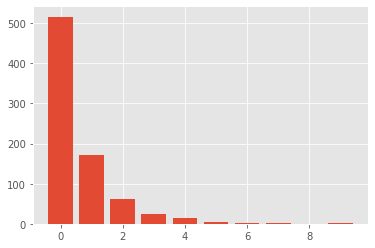

In [250]:
from matplotlib import pyplot as plt

counts = {}
for i in kaggle['Predict']:
    if i == '-1':
        if 0 in counts:
            counts[0] += 1
        else:
            counts[0] = 1
        continue

    num_author = len(i.split())
    if num_author in counts:
        counts[num_author] += 1
    else:
        counts[num_author] = 1

plt.bar(counts.keys(), counts.values())
plt.show()